# Fusion Model Development


### Classifers to try:

For explainability:
1. SVM - bad
2. RF
3. KNN - bad
4. XGBoost

Others to try (based on literature):

1. Lasso
2. ElasticNet
3. ??

### Results

Choose binary model based on best AUC score - try putting in the fusion model for now

In [57]:
import json

import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch.optim as optim
from torchinfo import summary
from torch.nn import functional as F
import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, hamming_loss, multilabel_confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.preprocessing import LabelBinarizer
#from torcheval.metrics import MulticlassAUROC

from sklearn import svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score

#for tuning
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

import seaborn as sn
import matplotlib.pyplot as plt

# Warning handling
import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 711

In [6]:
#load data
combined_train_df = pd.read_pickle(r'../data/combined_train_df_all_embeddings.pkl')
combined_val_df = pd.read_pickle(r'../data/combined_val_df_all_embeddings.pkl')
combined_test_df = pd.read_pickle(r'../data/combined_test_df_all_embeddings.pkl')

In [7]:
#merge train and val together
combined_train_val_df = pd.concat([combined_train_df, combined_val_df])

In [8]:
combined_train_df.columns

Index(['index', 'patient_id', 'visit_id', 'study_id', 'temperature',
       'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity',
       'positive_label_total', 'finding_names', 'radiology_note',
       'discharge_note', 'chief_complaint',
       'major_surgical_or_invasive_procedure', 'history_of_present_illness',
       'past_medical_history', 'family_history', 'atelectasis', 'cardiomegaly',
       'lung_opacity', 'pleural_effusion', 'dataset_type', 'dicom_id',
       'notes_classifications', 'notes_embeddings', 'notes_hidden_embeddings',
       'img_classifications', 'img_embeddings', 'img_densefeatures',
       'tabular_classifications0', 'tabular_classifications1',
       'tabular_classifications2', 'tabular_classifications3',
       'tabular_classifications4'],
      dtype='object')

In [9]:
combined_train_val_df.columns

Index(['index', 'patient_id', 'visit_id', 'study_id', 'temperature',
       'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity',
       'positive_label_total', 'finding_names', 'radiology_note',
       'discharge_note', 'chief_complaint',
       'major_surgical_or_invasive_procedure', 'history_of_present_illness',
       'past_medical_history', 'family_history', 'atelectasis', 'cardiomegaly',
       'lung_opacity', 'pleural_effusion', 'dataset_type', 'dicom_id',
       'notes_classifications', 'notes_embeddings', 'notes_hidden_embeddings',
       'img_classifications', 'img_embeddings', 'img_densefeatures',
       'tabular_classifications0', 'tabular_classifications1',
       'tabular_classifications2', 'tabular_classifications3',
       'tabular_classifications4'],
      dtype='object')

In [10]:
#create aggregated embeddings datasets
#loading datasets
train_x = combined_train_df[['tabular_classifications0', 'tabular_classifications1','tabular_classifications2', 
                             'tabular_classifications3','tabular_classifications4',
                             'notes_embeddings', 'notes_hidden_embeddings',
                            'img_embeddings', 'img_densefeatures']]
val_x = combined_val_df[['tabular_classifications0', 'tabular_classifications1','tabular_classifications2', 
                             'tabular_classifications3','tabular_classifications4',
                             'notes_embeddings', 'notes_hidden_embeddings',
                            'img_embeddings', 'img_densefeatures']]
test_x = combined_test_df[['tabular_classifications0', 'tabular_classifications1','tabular_classifications2', 
                             'tabular_classifications3','tabular_classifications4',
                             'notes_embeddings', 'notes_hidden_embeddings',
                            'img_embeddings', 'img_densefeatures']]
train_val_x = combined_train_val_df[['tabular_classifications0', 'tabular_classifications1','tabular_classifications2', 
                             'tabular_classifications3','tabular_classifications4',
                             'notes_embeddings', 'notes_hidden_embeddings',
                            'img_embeddings', 'img_densefeatures']]

train_y = combined_train_df['finding_names']
val_y = combined_val_df['finding_names']
test_y = combined_test_df['finding_names']
train_val_y = combined_train_val_df['finding_names']

print("TRAIN: shape of x: {}\nshape of y: {}".format(train_x.shape,train_y.shape))
print("VAL: shape of x: {}\nshape of y: {}".format(val_x.shape,val_y.shape))
print("TEST: shape of x: {}\nshape of y: {}".format(test_x.shape,test_y.shape))
print("TRAIN_VAL: shape of x: {}\nshape of y: {}".format(train_val_x.shape,train_val_y.shape))

TRAIN: shape of x: (2086, 9)
shape of y: (2086,)
VAL: shape of x: (1924, 9)
shape of y: (1924,)
TEST: shape of x: (1920, 9)
shape of y: (1920,)
TRAIN_VAL: shape of x: (4010, 9)
shape of y: (4010,)


In [11]:
def reshape_data(data):
    #gets rid of nested embeddings
    flattened_data = pd.DataFrame()
    
    for col in data.columns:
        data[col] = data[col].apply(np.ravel)

        col_names = []
        for i in range(data[col][0].shape[0]):
            col_name = col + str(i)
            col_names.append(col_name)

        flattened_data[col_names] = pd.DataFrame(data[col].tolist(), index= data.index)
    
    return flattened_data

In [48]:
#reshape data
#train_x = reshape_data(train_x)
#val_x = reshape_data(val_x)
#test_x = reshape_data(test_x)
#train_val_x = reshape_data(train_val_x)

print("TRAIN: shape of x: {}\nshape of y: {}".format(train_x.shape,train_y.shape))
print("VAL: shape of x: {}\nshape of y: {}".format(val_x.shape,val_y.shape))
print("TEST: shape of x: {}\nshape of y: {}".format(test_x.shape,test_y.shape))
#print("TRAIN_VAL: shape of x: {}\nshape of y: {}".format(train_val_x.shape,train_val_y.shape))

TRAIN: shape of x: (2086, 1752)
shape of y: (2086,)
VAL: shape of x: (1924, 1752)
shape of y: (1924,)
TEST: shape of x: (1920, 1752)
shape of y: (1920,)


In [13]:
train_x.head()

,tabular_classifications00,tabular_classifications10,tabular_classifications20,tabular_classifications30,tabular_classifications40,notes_embeddings0,notes_embeddings1,notes_embeddings2,notes_embeddings3,notes_embeddings4,...,img_densefeatures1526,img_densefeatures1527,img_densefeatures1528,img_densefeatures1529,img_densefeatures1530,img_densefeatures1531,img_densefeatures1532,img_densefeatures1533,img_densefeatures1534,img_densefeatures1535
0,0.208681,0.158534,0.110880,0.248646,0.273259,-0.267226,0.647106,-1.171433,0.907014,-0.266587,...,0.604024,0.847728,0.235411,0.730207,0.068122,0.857000,0.055642,0.004653,0.111292,0.237230
1,0.312157,0.195341,0.144800,0.174402,0.173300,1.196290,0.296975,0.412586,-0.559608,-1.431168,...,0.636729,0.731136,0.186779,0.619654,0.222132,0.733983,0.154528,0.018952,0.088321,0.213648
2,0.396899,0.157088,0.163143,0.136013,0.146858,1.191423,0.430787,0.139417,-0.123266,-1.317708,...,0.908274,0.968641,0.257039,0.997114,0.093494,1.075215,0.088319,0.007294,0.080976,0.213116
3,0.290064,0.176080,0.165073,0.162788,0.205994,0.443146,1.201157,-1.000020,-0.463639,-0.203990,...,0.980167,1.070965,0.229824,0.877981,0.058277,1.270879,0.053015,0.012560,0.166239,0.218688
4,0.413125,0.163641,0.124322,0.176546,0.122366,0.673903,1.203965,-1.104689,0.167685,-0.888483,...,0.857741,0.895503,0.378214,0.444787,0.078207,0.910277,0.102543,0.052296,0.186534,0.183555


In [14]:
#combine training and validation datasets for crossvalidation testing

#merge train and val together and serparate
train_val_x = pd.concat([train_x, val_x])
train_val_y = pd.concat([train_y, val_y])

print("TRAIN_VAL: shape of x: {}\nshape of y: {}".format(train_val_x.shape,train_val_y.shape))

TRAIN_VAL: shape of x: (4010, 1752)
shape of y: (4010,)


In [15]:
#recode y classes as integers
target_variables_dict = {
    'no_finding': 0,
    'atelectasis': 1,
    'cardiomegaly': 2,
    'lung_opacity': 3,
    'pleural_effusion': 4,
}

def recode_features(data):
    data = data.replace("no_finding", 0)
    data = data.replace("atelectasis", 1)
    data = data.replace("cardiomegaly", 2)
    data = data.replace("lung_opacity", 3)
    data = data.replace("pleural_effusion", 4)
    return data

train_y = recode_features(train_y)
val_y = recode_features(val_y)
test_y = recode_features(test_y)
train_val_y = recode_features(train_val_y)

In [16]:
#feature scaling
sc = StandardScaler()

train_x = sc.fit_transform(train_x)
val_x = sc.fit_transform(val_x)
test_x = sc.fit_transform(test_x)
train_val_x = sc.fit_transform(train_val_x)

In [34]:
#adjust parameters
BATCH_SIZE = 64
LEARNING_RATE = 0.01
EPOCHS = 1000

# Functions for metrics

In [29]:
class_label = ['No_Findings', 'Atelatsis', 'Cardiomegaly', 'Lung_Opacity', 'Pleural_Effusion']

def create_roc_auc_curve_others(model, X_val, y_val, average = 'macro'): 
    lw = 2
    fig, c_ax = plt.subplots(1,1, figsize = (12,8))

    pred = model.predict(X_val)
    lb = LabelBinarizer()
    lb.fit(y_val) 
    y_val = lb.transform(y_val) 
    pred = lb.transform(pred) 
    
    for (idx, c_label) in enumerate(class_label): 
        fpr, tpr, thresholds = roc_curve(y_val[:, idx].astype(int), pred[:, idx]) 
        c_ax.plot(fpr, tpr, label = "%s (AUC_%0.2f)" % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing') 
    c_ax.legend()
    c_ax.set_xlabel("False Positive Rate")
    c_ax.set_ylabel("True Posistive Rate") 
    plt.show()
    
    ROCAUCScore = roc_auc_score(y_val, pred, average = average) 
    print('ROC AUC Score---------->')
    print("{0:.3f}".format(ROCAUCScore))
    return None

In [34]:
def get_metrics_others(model, X_train, y_train, X_val, y_val): 
    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)
    acc_score_train = accuracy_score(y_train, pred_train)
    acc_score_val = accuracy_score(y_val, pred_val)
    rec_score = recall_score(y_val, pred_val,average ="weighted")
    prec_score = precision_score(y_val, pred_val,average ="weighted")
    f1score = f1_score(y_val, pred_val ,average ="weighted")
    print("Training accuracy score---------->")
    print("{0:.3f}".format(acc_score_train*100),"%")
    
    print("Validation accuracy score-------->")
    print("{0:.3f}".format(acc_score_val *100), "%")
    
    print("Recall score---------->")
    print("{0:.3f}".format(rec_score * 100), "%") 
    
    print("Precision score---------->") 
    print("{0:.3f}".format(prec_score * 100), "%")
    
    print("F1 score---------->")
    print("{0:.3f}".format(f1score * 100),"%") 
    return acc_score_train, acc_score_val, rec_score, prec_score, f1score 

## SVM

In [55]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(train_val_x, y_train.ravel())

#Predict the response for test dataset
y_pred = clf.predict(X_val)

In [57]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf', 'linear']}  
  
grid = GridSearchCV(clf, param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train.ravel()) 

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.337 total time=   5.2s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.336 total time=   4.9s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.336 total time=   4.9s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.338 total time=   5.6s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.338 total time=   5.3s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.897 total time=   0.6s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.911 total time=   0.6s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.911 total time=   0.5s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.882 total time=   0.6s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.904 total time=   0.6s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.337 total time=   4.6s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

GridSearchCV(estimator=SVC(kernel='linear'),
             param_grid={'C': [0.1, 1, 10],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear']},
             verbose=3)

In [58]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=1, gamma=0.001)


# Create SVM CLassifier on train_val for the test set

In [19]:
#Create a svm Classifier
clf = svm.SVC(kernel='rbf', gamma = 0.001, C = 1) # Linear Kernel

#Train the model using the training sets
clf.fit(train_val_x, train_val_y.ravel())

#Predict the response for test dataset
y_pred = clf.predict(test_x)

In [21]:
# print classification report 
print(classification_report(test_y, y_pred)) 

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1376
           1       0.17      0.18      0.17       112
           2       0.37      0.36      0.37       128
           3       0.38      0.33      0.35       219
           4       0.37      0.49      0.42        85

    accuracy                           0.68      1920
   macro avg       0.42      0.44      0.43      1920
weighted avg       0.68      0.68      0.68      1920



In [24]:
confusion_matrix(test_y, y_pred)

array([[1122,   72,   56,   90,   36],
       [  61,   20,    9,   11,   11],
       [  57,    5,   46,   14,    6],
       [ 101,   18,    9,   73,   18],
       [  31,    3,    4,    5,   42]], dtype=int64)

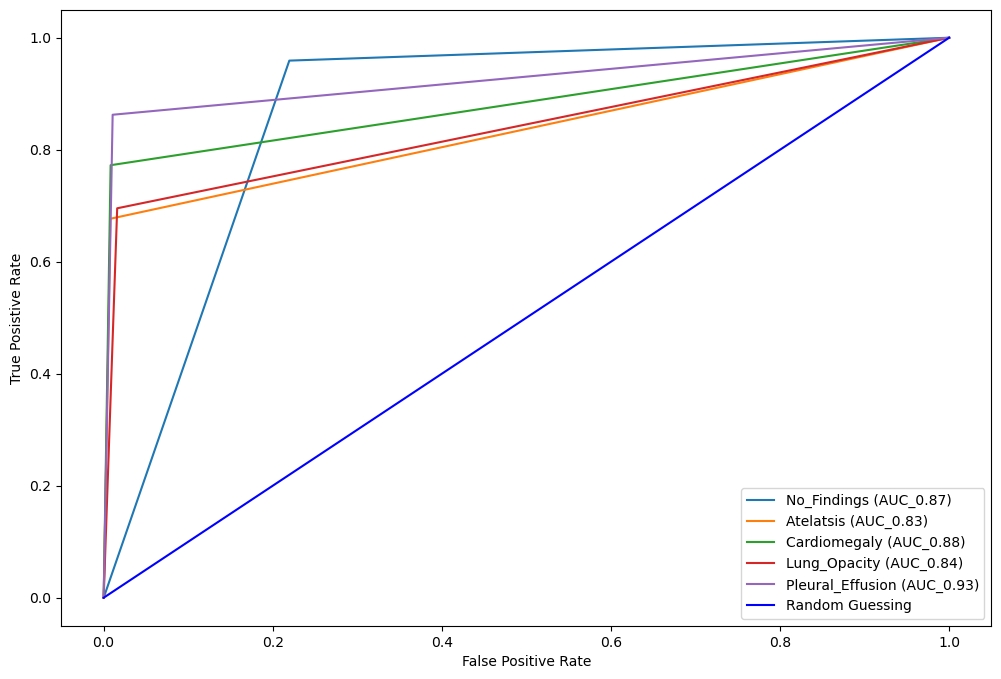

ROC AUC Score---------->
0.870


In [30]:
create_roc_auc_curve_others(clf, train_val_x, train_val_y)

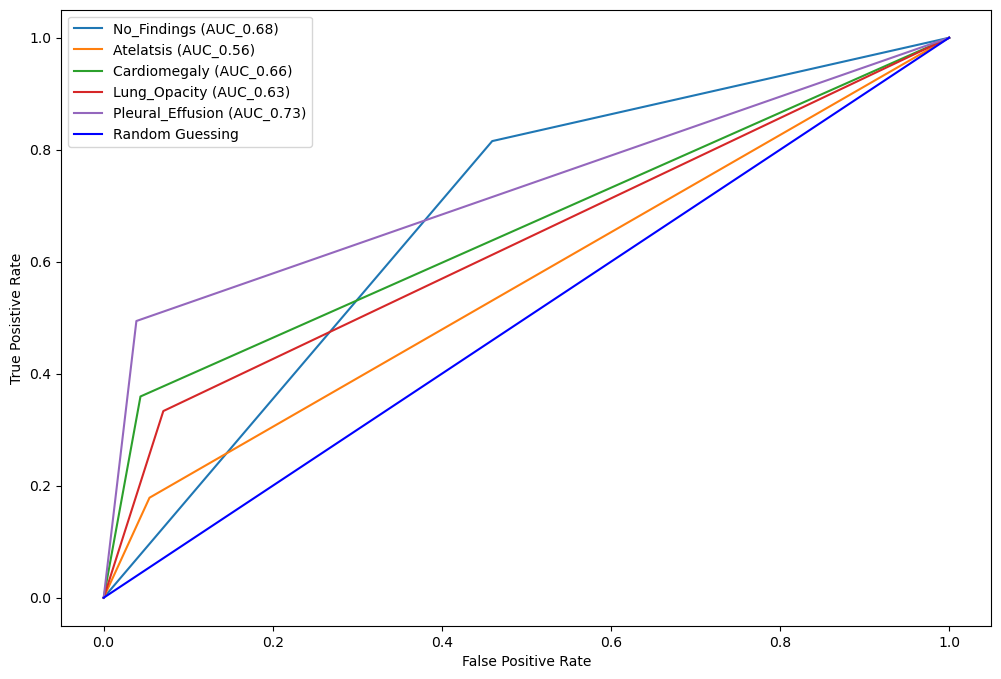

ROC AUC Score---------->
0.651


In [31]:
create_roc_auc_curve_others(clf, test_x, test_y)

# Random Forest

In [131]:
##random search for Random Forest (grid search takes more time)
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=0),
                           {
                              'n_estimators':np.arange(10,100,10),
                              'max_depth': [10, 100, None],
                              'min_samples_leaf': [1, 2],
                              'min_samples_split': [2, 5]
                            },cv=3, scoring="r2",verbose=1,n_jobs=-1, 
                             n_iter=10, random_state = 0
                           )
random_search.fit(X_train,y_train.ravel())

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 100, None],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   random_state=0, scoring='r2', verbose=1)

In [132]:
#checking the best parameters
print(random_search.best_params_)

{'n_estimators': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}


In [133]:
#dictionary of best results
results_df = pd.DataFrame(random_search.cv_results_).sort_values(by = 'rank_test_score', ascending = True)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,1.300020,0.052900,0.010988,0.002439,20,5,2,None,"{'n_estimators': 20, 'min_samples_split': 5, '...",0.813457,0.758163,0.839779,0.803800,0.034012,1
9,5.973610,0.164820,0.012336,0.000944,60,5,1,None,"{'n_estimators': 60, 'min_samples_split': 5, '...",0.823785,0.751697,0.832672,0.802718,0.036259,2
0,2.381775,0.031811,0.016105,0.003893,40,5,1,None,"{'n_estimators': 40, 'min_samples_split': 5, '...",0.817330,0.748464,0.841717,0.802504,0.039488,3
2,2.441813,0.055699,0.014045,0.000869,40,2,1,None,"{'n_estimators': 40, 'min_samples_split': 2, '...",0.818621,0.751050,0.834611,0.801427,0.036215,4
4,4.943055,0.291062,0.092658,0.016377,70,2,2,10,"{'n_estimators': 70, 'min_samples_split': 2, '...",0.822494,0.731005,0.837195,0.796898,0.046978,5
6,12.712907,0.376418,0.103337,0.026050,90,5,2,None,"{'n_estimators': 90, 'min_samples_split': 5, '...",0.817975,0.721952,0.844301,0.794743,0.052581,6
3,1.798719,0.106750,0.018005,0.003555,30,2,1,10,"{'n_estimators': 30, 'min_samples_split': 2, '...",0.792156,0.767863,0.821690,0.793903,0.022009,7
8,11.144422,2.707150,0.024922,0.009544,80,5,1,10,"{'n_estimators': 80, 'min_samples_split': 5, '...",0.820557,0.717426,0.835903,0.791295,0.052608,8
7,12.502574,1.073238,0.067260,0.031257,80,2,1,10,"{'n_estimators': 80, 'min_samples_split': 2, '...",0.817975,0.716779,0.838487,0.791081,0.053202,9
1,1.205999,0.036360,0.007335,0.000470,20,5,1,10,"{'n_estimators': 20, 'min_samples_split': 5, '...",0.803775,0.719366,0.835257,0.786132,0.048929,10


# Train RF on trian_val data

In [32]:
#run RF with the best parameters
model_rf = RandomForestClassifier(n_estimators = 20, min_samples_split = 5, min_samples_leaf = 2, max_depth = None)

In [33]:
history_rf = model_rf.fit(train_val_x, train_val_y.ravel()) 

In [37]:
rf_acc_train, rf_acc_test, rf_rec, rf_prec, rf_f1 = get_metrics_others(model_rf, train_val_x, train_val_y, test_x, test_y)

Training accuracy score---------->
96.509 %
Validation accuracy score-------->
63.542 %
Recall score---------->
63.542 %
Precision score---------->
67.260 %
F1 score---------->
65.132 %


In [39]:
pred_y_rf = model_rf.predict(test_x)
confusion_matrix(test_y, pred_y_rf)

array([[1035,  104,   77,  113,   47],
       [  51,   21,    8,   18,   14],
       [  51,    5,   49,   17,    6],
       [  92,   26,   12,   69,   20],
       [  22,    5,    4,    8,   46]], dtype=int64)

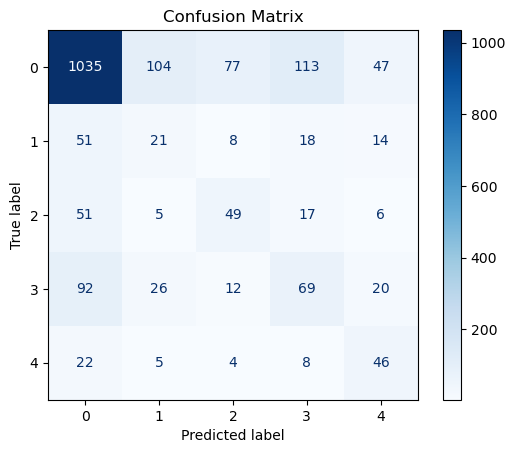

In [50]:
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_y, pred_y_rf), display_labels=np.unique(train_y))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

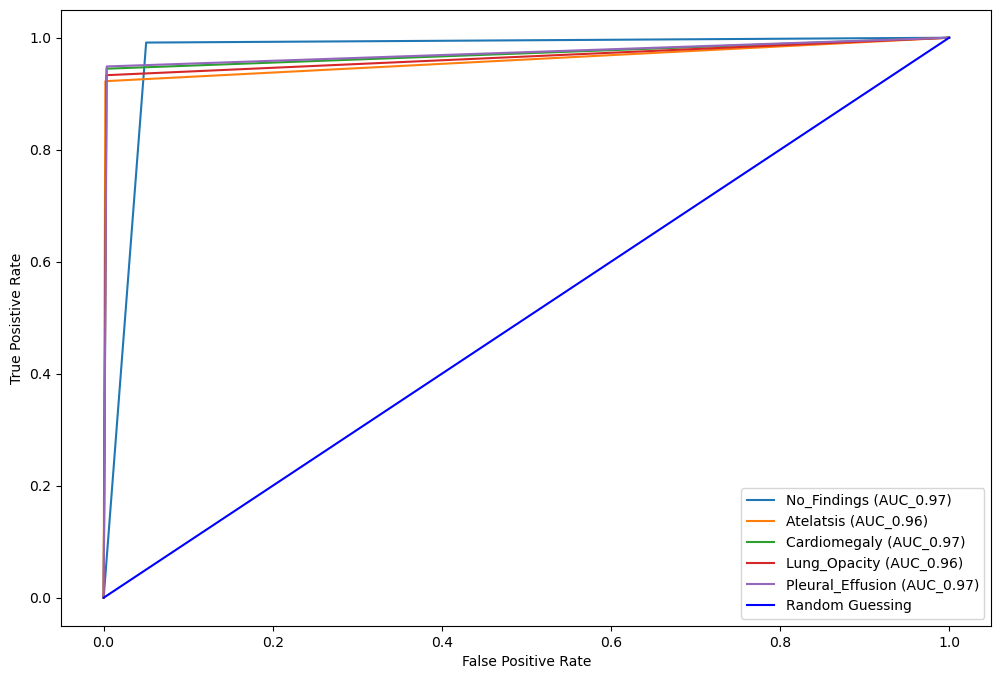

ROC AUC Score---------->
0.968


In [42]:
create_roc_auc_curve_others(model_rf, train_val_x, train_val_y)

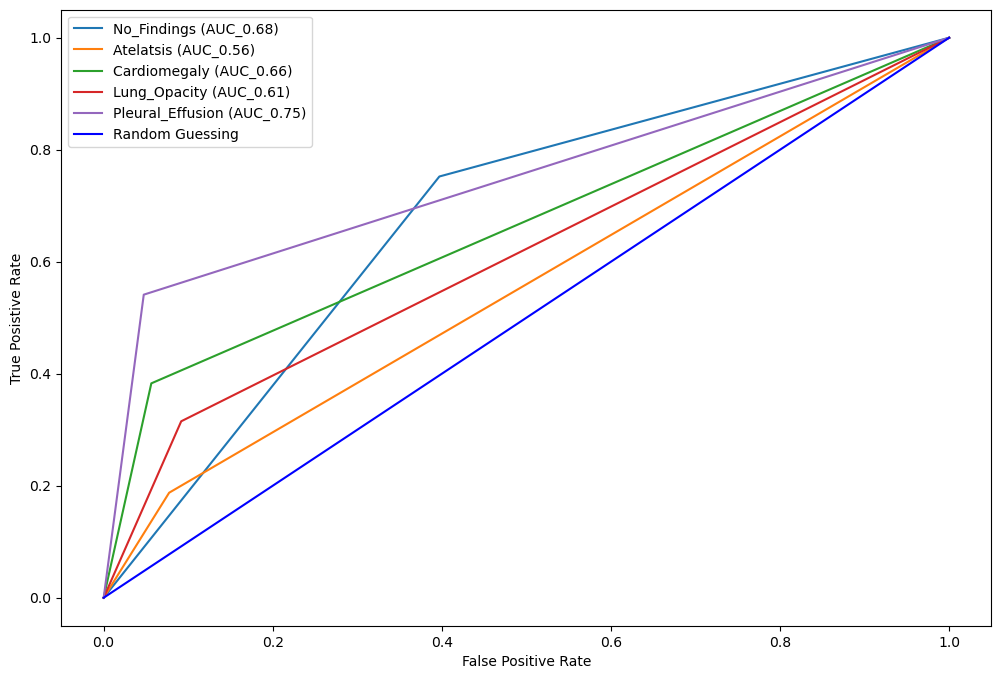

ROC AUC Score---------->
0.651


In [43]:
create_roc_auc_curve_others(model_rf, test_x, test_y)

# XGBoost

In [51]:
# Setup default parameters for gridsearch
params={
        #Boosting parameters
        'estimator__learning_rate':    [0.05,0.01,0.005],   
        'estimator__n_estimators':     range(200,500,20),
        'estimator__max_depth':        [1,2],    
        'estimator__min_child_weight': [1,2],
        'estimator__gamma':            [0],
        'estimator__subsample':        [0.5,0.7],  
        'estimator__colsample_bytree': [0.25],
        'estimator__colsample_bylevel':[0.],
        'estimator__colsample_bynode': [0.],
        'estimator__reg_alpha':        [0, 0.5],
        'estimator__reg_lambda':       [0.],
        #'estimator__scale_pos_weight': [1],  # Not used for multi classifications
        'estimator__max_delta_step':   [0],   # 0 for no constraint
        'estimator__monotone_constraints':    [None],
        'estimator__interaction_constraints': [None],
        #Learning task parameters
        'estimator__tree_method':      ['hist'],
        'estimator__base_score':       [0.5],
}

In [ ]:
#begin gridsearch
xgb_classifier = xgb.XGBClassifier(eta = 0.1)

auc_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr', average='weighted')
Grid = RandomizedSearchCV(xgb_classifier, param_distributions=params,
                    scoring={'neg_log_loss': 'neg_log_loss',
                             'roc_auc_ovr': auc_scorer},
                    return_train_score=True,
                    refit='roc_auc_ovr',
                    cv=5,
                    verbose=1,
                    n_jobs=-1, 
                    n_iter=10, random_state = RANDOM_SEED).fit(train_x, train_y)

# Create dataframe of the results for comparison & analysis
Griddf = pd.DataFrame(Grid.cv_results_)

# Print the best AUC score and associated parameters
print("Best AUC Score: ", Grid.best_score_)
print("Best Parameters: ", Grid.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


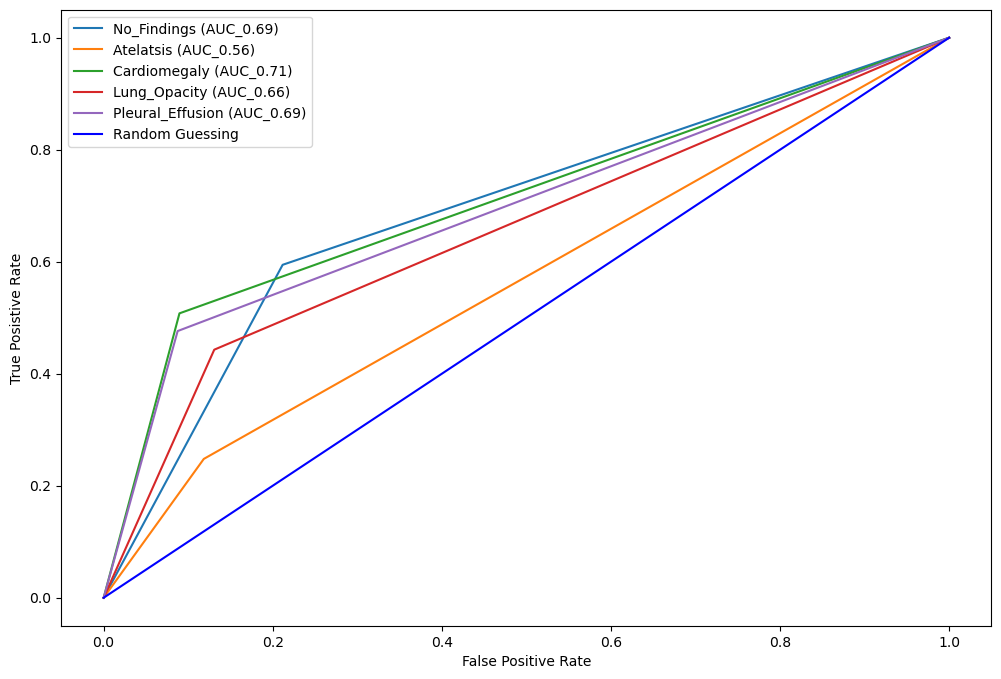

ROC AUC Score---------->
0.663


In [139]:
xgb_classifier = xgb.XGBClassifier(eta = 0.1)
history_xgb = xgb_classifier.fit(train_val_x, train_val_y)

create_roc_auc_curve_others(xgb_classifier, train_val_x, train_val_y)

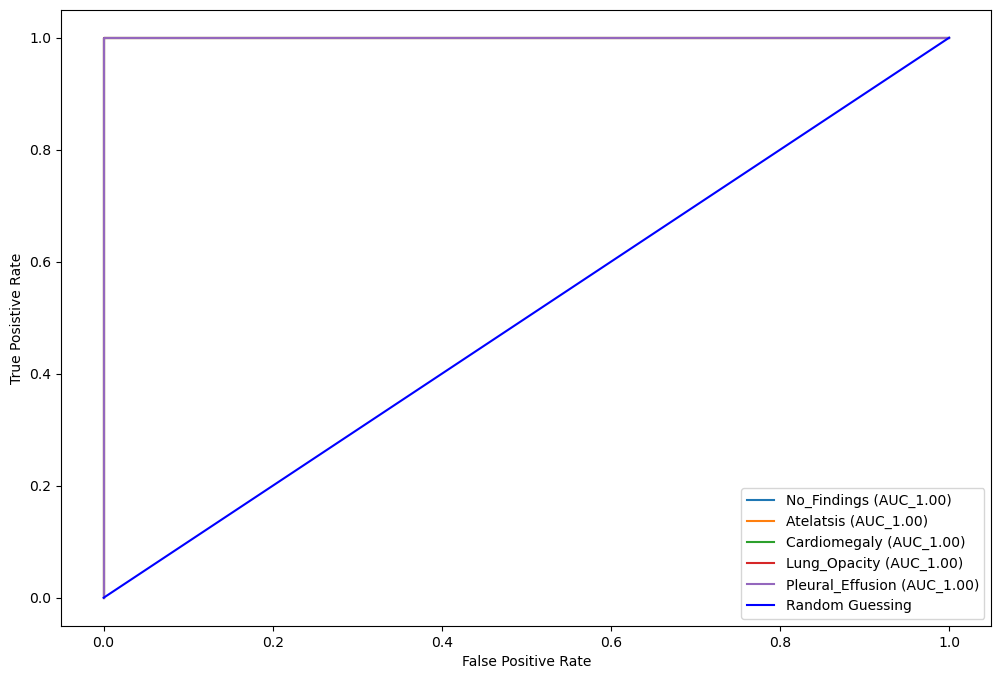

ROC AUC Score---------->
1.000


In [143]:
create_roc_auc_curve_others(xgb_classifier, test_x, test_y)

In [145]:
pred_xgb = xgb_classifier.predict(test_x)
confusion_matrix(test_y, pred_xgb)

array([[818, 167, 115, 176, 100],
       [ 37,  29,  18,  25,   8],
       [ 22,  14,  65,   8,  19],
       [ 42,  27,  19,  97,  34],
       [ 15,   6,   9,  14,  40]], dtype=int64)

In [ ]:
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_y, pred_xgb), display_labels=np.unique(train_y))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Summary

RF and XGB best performers - combine training and val, perform cross validation similar to Adam for final models